案例：tianmao

## 分析背景
“天猫”（英文：Tmail，亦称淘宝商城，天猫商城）原名淘宝商城，是一个综合性购物网站，也是马云淘宝网打造的B2C(Business-to-Consumer, 商业零售)品牌。其整合数千家品牌商、生产商，为商家和消费者之间提供一站式解决方案，提供100%品质保证的商品，7天无理由退货的售后服务，以及购物积分返现等优质服务

## 分析目标
根据用户数据以及消费行为数据
- 使用Python建立分类模型，进行逻辑回归
- 预测使用优惠券概率较高的客群

# 1 数据概况分析

## 1.1 数据预览

### 指标解释
- ID	记录编码

- age	年龄

- job	职业

- marital	婚姻状态

- default	花呗是否有违约

- returned	是否有过退货

- loan	是否使用花呗结账

- coupon_used_in_last6_month	过去六个月使用的优惠券数量

- coupon_used_in_last_month	过去一个月使用的优惠券数量

- coupon_ind	该次活动中是否有使用优惠券

In [1]:
#导入模块和数据
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

coupon = pd.read_csv('tianmao.csv')
coupon.head()

,ID,age,job,marital,default,returned,loan,coupon_used_in_last6_month,coupon_used_in_last_month,coupon_ind
0,1,43,management,married,no,yes,no,2,0,0
1,2,42,technician,divorced,no,yes,no,1,1,0
2,3,47,admin.,married,no,yes,yes,2,0,0
3,4,28,management,single,no,yes,yes,2,0,0
4,5,42,technician,divorced,no,yes,no,5,0,0


In [10]:
#查看数据行列总数
coupon.shape

(25317, 10)

In [11]:
#查看数据是否有缺失值
coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25317 entries, 0 to 25316
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          25317 non-null  int64 
 1   age                         25317 non-null  int64 
 2   job                         25317 non-null  object
 3   marital                     25317 non-null  object
 4   default                     25317 non-null  object
 5   returned                    25317 non-null  object
 6   loan                        25317 non-null  object
 7   coupon_used_in_last6_month  25317 non-null  int64 
 8   coupon_used_in_last_month   25317 non-null  int64 
 9   coupon_ind                  25317 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.9+ MB


查看完数据整体后，发现无缺失值

## 1.2 数据清洗

### 1.2.1 类别型变量

In [2]:
#将类别型变量转换为数字型变量，便于之后分析
#但在本案例中，为了后续分析方便，只处理default, returned, loan这三个变量，保留job, marital 
#把default、returned、loan三个变量单独取出来进行哑变量处理get_dummies()。
coupon1 = coupon[['default','returned','loan']]
coupon1 = pd.get_dummies(coupon1)
coupon1.head()

,default_no,default_yes,returned_no,returned_yes,loan_no,loan_yes
0,1,0,0,1,1,0
1,1,0,0,1,1,0
2,1,0,0,1,0,1
3,1,0,0,1,0,1
4,1,0,0,1,1,0


In [5]:
#把处理后的表格和原表格进行拼接
coupon = pd.concat([coupon, coupon1], axis = 1)
coupon.head()

,ID,age,job,marital,default,returned,loan,coupon_used_in_last6_month,coupon_used_in_last_month,coupon_ind,default_no,default_yes,returned_no,returned_yes,loan_no,loan_yes
0,1,43,management,married,no,yes,no,2,0,0,1,0,0,1,1,0
1,2,42,technician,divorced,no,yes,no,1,1,0,1,0,0,1,1,0
2,3,47,admin.,married,no,yes,yes,2,0,0,1,0,0,1,0,1
3,4,28,management,single,no,yes,yes,2,0,0,1,0,0,1,0,1
4,5,42,technician,divorced,no,yes,no,5,0,0,1,0,0,1,1,0


In [6]:
#删除包含重复信息和无意义信息的数据
coupon.drop(['ID', 'default', 'default_no', 'returned', 'returned_no', 'loan', 'loan_no'], axis = 1, inplace = True)

#将coupon_ind重新命名为flag，便于之后分析
coupon = coupon.rename(columns = {'coupon_ind' : 'flag'})
coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25317 entries, 0 to 25316
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   age                         25317 non-null  int64 
 1   job                         25317 non-null  object
 2   marital                     25317 non-null  object
 3   coupon_used_in_last6_month  25317 non-null  int64 
 4   coupon_used_in_last_month   25317 non-null  int64 
 5   flag                        25317 non-null  int64 
 6   default_yes                 25317 non-null  uint8 
 7   returned_yes                25317 non-null  uint8 
 8   loan_yes                    25317 non-null  uint8 
dtypes: int64(4), object(2), uint8(3)
memory usage: 1.2+ MB


# 2 单变量分析

## 2.1 观察样本0、1的平衡性

In [7]:
#二分类模型，观察样本(flag)0,1的平衡性
coupon['flag'].value_counts(1)

0    0.883043
1    0.116957
Name: flag, dtype: float64

- 在二分类问题中，0、1的占比要保持平衡型，实际情况中不低于0.05，否则会影响模型的预测
- 该数据集0、1占比均高于0.05，因此其分布是合理的

## 2.2 观察均值大小

In [8]:
#先按客户是否使用coupon进行分类聚合
summary = coupon.groupby(['flag'])
#求出各种情况均值的占比情况
summary.mean()

,age,coupon_used_in_last6_month,coupon_used_in_last_month,default_yes,returned_yes,loan_yes
flag,,,,,,
0,40.819601,2.857846,0.260378,0.018876,0.579755,0.169037
1,41.809524,2.124282,0.537994,0.008781,0.357649,0.094563


### 对于数据类型为0和1的变量，观察均值大小可以帮助我们分析这个变量在flag上的分布：
- coupon_used_in_last_month在0的均值为0.26，在1的均值为0.53，说明越是在上个月使用了coupon的客户，接下来再使用coupon的概率会越高
- default_yes和loan_yes在0时的均值均大于在1时的均值，说明花呗违约和用花呗结账的客户在接下来的时间里使用coupon的概率较小
- age在0和1的均值分别为40.8和41.8，差别不大，说明年龄无太大的区分关系

## 2.3 可视化

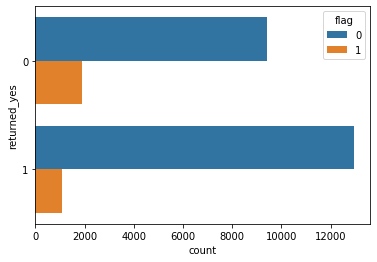

In [9]:
#观察returned_yes在flag上的分布
sns.countplot(y = 'returned_yes', hue = 'flag', data = coupon)

- 相比起没有退货的客户，退货的客户使用coupon的概率较小

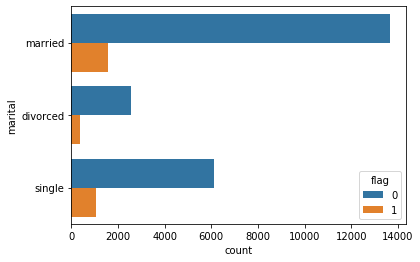

In [11]:
#观察marital在flag上的分布
sns.countplot(y = 'marital', hue = 'flag', data = coupon)

- 已婚客户使用coupon的概率比未婚和离婚客户使用coupon的概率略高
- 已婚人士未使用coupon的概率比未婚人士未使用coupon的概率也要高
- 但是三者均未使用coupon的概率比使用coupon的概率要高得多

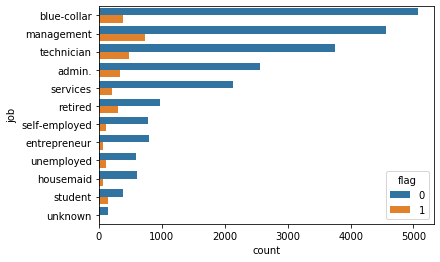

In [24]:
#观察job在flag上的分布
sns.countplot(y = 'job', hue = 'flag', data = coupon, order = coupon['job'].value_counts().index)

- job title为management, technician, blue-collar的客户越有可能使用coupon

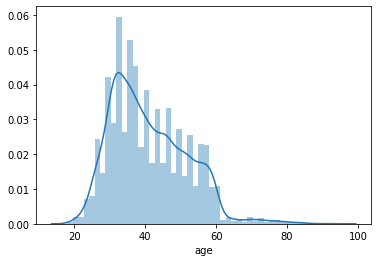

In [25]:
#观察age在flag上的分布
sns.distplot(coupon['age'])

In [39]:
#查看age在整体数据的分布情况
coupon['age'].describe()

count    25317.000000
mean        40.935379
std         10.634289
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

- 数据显示18 - 95岁的客户使用coupon可能性较高，使用coupon概率较高的客群集中在40岁
- 发现age > 60岁的极端值较少，但它们影响了整体数据分布，需要把这部分数据剔除在分析范围外

In [35]:
#对于年龄进行快速分组，探究各个年龄段对于是否使用coupon的影响
age60 = coupon[coupon['age'] < 60]
bins = [0, 20, 40, 60]
labels = ['<20','<40','<60']
age60['age_new'] = pd.cut(age60.age, bins, right=False,labels = labels)
age60.groupby(['age_new'])['age'].describe()

,count,mean,std,min,25%,50%,75%,max
age_new,,,,,,,,
<20,25.0,18.760000,0.435890,18.0,19.0,19.0,19.0,19.0
<40,13063.0,32.569624,4.130196,20.0,30.0,33.0,36.0,39.0
<60,11215.0,48.416942,5.720111,40.0,43.0,48.0,53.0,59.0


In [43]:
age60['age_new'].describe()

count     24303
unique        3
top         <40
freq      13063
Name: age_new, dtype: object

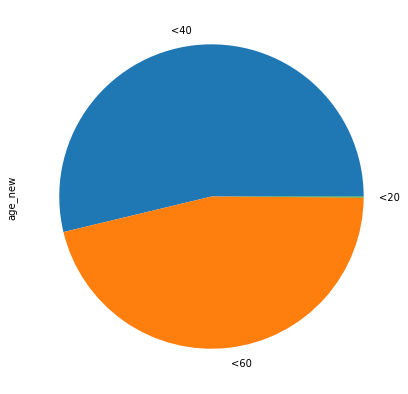

In [69]:
#绘制age60['age_new']的饼图，使数据更加直观
plt.figure(figsize=[9,7])
age60['age_new'].value_counts().plot.pie()
plt.show()

- 20 - 40岁的客群使用coupon概率最高
- 18，32，48岁分别为三个年龄段中使用coupon概率较高的年龄平均值

# 3 相关和可视化

In [71]:
#围绕flag变量，观察它与其他变量的关系
coupon.corr()[['flag']].sort_values('flag', ascending = False)

,flag
flag,1.000000
coupon_used_in_last_month,0.116550
age,0.029916
default_yes,-0.024608
loan_yes,-0.065231
coupon_used_in_last6_month,-0.075173
returned_yes,-0.143589


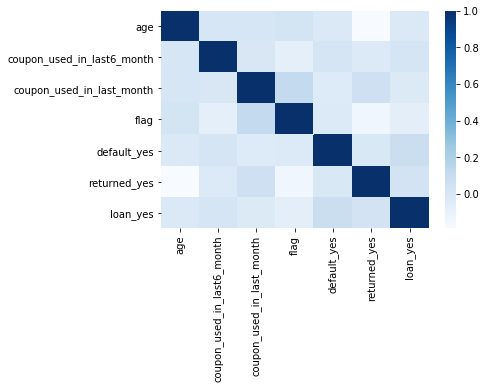

In [72]:
sns.heatmap(coupon.corr(), cmap = 'Blues')

- flag与coupon_used_in_last_month, age成强正相关关系
- flag与coupon_used_in_last6_month, returned_yes成强负相关关系
- 其他变量与flag的相关不明显，为了分析准确性，因此不做过度解读

# 4 逻辑回归模型的建立和评估

## 4.1 模型建立


### 4.1.1 抽取训练集和测试集并进行拟合

In [81]:
#先设定自变量x和因变量y
x = coupon[['coupon_used_in_last_month', 'returned_yes', 'loan_yes']]
y = coupon['flag']

In [121]:
#调用sklearn模块，随机抽取训练集和测试集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100) #训练集和测试集抽取比例为70/30

#调用sklearn中逻辑回归模块
from sklearn import linear_model
lr = linear_model.LogisticRegression()

#拟合
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 4.1.2 查看模型结果

In [85]:
#查看系数
lr.coef_

array([[ 0.38674154, -0.95906584, -0.56226592]])

- 当coupon_used_in_last_month从0到1时，不使用coupon到使用coupon的概率提升是e的0.38，即是其他组客户的1.46倍
- 当returned_yes从1到0时，使用coupon到不使用coupon的概率提升是其他组客户的0.38倍
- 当loan_yes从1到0时，使用coupon到不使用coupon的概率提升是其他组客户的0.57倍
- 故从概率来看，上月使用过coupon的客户、未退货客户和未用花呗付款的客群再使用coupon的概率会更高。

In [86]:
#查看截距
lr.intercept_

array([-1.63641623])

## 4.2 模型评估

### 4.2.1 评估方法一：计算准确度

In [87]:
#通过训练集和测试集的自变量x，分别计算出对应的预测值
y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)

In [88]:
#搭建训练集混淆矩阵
from sklearn import metrics
metrics.confusion_matrix(y_train, y_pred_train)

array([[15596,    27],
       [ 2092,     6]])

In [89]:
#查看训练集准确率
metrics.accuracy_score(y_train, y_pred_train)

0.8804243552846904

In [90]:
#搭建测试集混淆矩阵
metrics.confusion_matrix(y_test, y_pred_test)

array([[6722,   11],
       [ 862,    1]])

In [91]:
#查看测试集准确率
metrics.accuracy_score(y_test, y_pred_test)

0.8850710900473934

#### 比较训练集和测试集的准确率，保证内在信息一致性:
- 模型在train和test的表现中不能相差过大。案例中训练集与测试集的准确率相差很小，故该模型是合理的
- 但是未来客群和特点都可能会发生变化，需要做出自己的平衡。train和test只是帮助建立一个概念，不要为了单独的模型太过追求准确率

### 4.2.2 评估方法二：ROC和AUC

In [94]:
#使用auc评估模型
from sklearn.metrics import roc_curve, auc
fpr,tpr,threshold = roc_curve(y_train, y_pred_train)
roc_auc = auc(fpr,tpr)

print(roc_auc)

0.5005658226636232


一般好的模型评分在0.7 - 0.8之间，故此模型需要被调整

## 4.3 模型优化

In [136]:
#新增变量returned_yes
x = coupon[['coupon_used_in_last_month', 'returned_yes', 'loan_yes', 'coupon_used_in_last6_month', 'default_yes', 'age']]
y = coupon['flag']

In [137]:
#调用sklearn模块，随机抽取训练集和测试集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100) #训练集和测试集抽取比例为70/30

#调用sklearn中逻辑回归模块
from sklearn import linear_model
lr = linear_model.LogisticRegression()

#拟合
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [138]:
lr.coef_

array([[ 0.43301838, -0.98377924, -0.53258362, -0.16774917, -0.53712933,
         0.00114054]])

In [139]:
#使用auc评估模型
from sklearn.metrics import roc_curve, auc
fpr,tpr,threshold = roc_curve(y_train, y_pred_train)
roc_auc = auc(fpr,tpr)

print(roc_auc)

0.5005658226636232


- 只有coupon_used_in_last_month, age和flag的成正相关关系，其他变量与flag均为反相关关系
- 模型迭代后AUC评分变化不大，说明coupon的使用率明显较低

# 5 业务建议

## 5.1 用户分析

- 数据显示18 - 95岁的客户使用coupon可能性较高，使用coupon概率较高的客群集中在40岁
- 20 - 40岁的客群使用coupon概率最高
- 18，32，48岁分别为三个年龄段中使用coupon概率较高的年龄平均值

## 5.2 提高优惠券使用率分析 - 高价值用户

- coupon_used_in_last_month在0的均值为0.26，在1的均值为0.53，说明越是在上个月使用了coupon的客户，接下来再使用coupon的概率会越高
- default_yes和loan_yes在0时的均值均大于在1时的均值，说明花呗违约和用花呗结账的客户在接下来的时间里使用coupon的概率较小


- 相比起没有退货的客户，退货的客户使用coupon的概率较小
- 已婚客户使用coupon的概率比未婚和离婚客户使用coupon的概率略高
- job title为management, technician, blue-collar的客户越有可能使用coupon


- flag与coupon_used_in_last_month, age成强正相关关系
- flag与coupon_used_in_last6_month, returned_yes成强负相关关系
- 其他变量与flag的相关性都不明显

## 5.3 结论

- 天猫优惠券的使用率较低
- 重点留意20 - 60客户的留存情况，对有购买潜力或者购买种类比较单一的客户，制定向上销售模型或交叉销售模型，提升现有客户价值
- 鼓励上月用过优惠券的客户再次使用优惠券，制定相应的产品响应模型或活动响应模型，最大化收益
- 对无退货客户、已婚客户、无花呗违约和未用花呗结账的用户制定客户流失预警模型或者客户赢回模型，其次是管理、技术员和蓝领阶层，尽量挽回客户
- 加大APP内优惠券的宣传力度，加强banner、广告推送等营销措施；在APP外进行额外推送、第三方优惠券推送，让客户了解并提升使用优惠券的概率